# Assignment 2, Question 2: Robots that learn how to learn

##### Instructions:
* Please complete the assignments in this notebook. You should submit this notebook, as well as a PDF version, to blackboard.
* To create the PDF, see File > Download as. You can export to PDF via Latex, or export to HTML and then print to PDF.
* Check your code before submission. It should be possible to reproduce all your results via 'run all'.
* Add a clear explanation of your approach and an in-depth interpretation of your results for every subquestion. Use markdown cells for this.
* Keep the PDF for each question below 15 pages. Remove these instructions in the final PDF.
* Avoid all unnecessary outputs. Only output the answers to the questions. Add ';' behind lines that generate output to suppress the output.
* Add the names of all team members below.

TEAM MEMBER 1 = ...  
TEAM MEMBER 2 = ...  
TEAM MEMBER 3 = ...  
TEAM MEMBER 4 = ...  

(Add a short description of what each team member contributed)  

In [4]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

# Extra imports
from scipy.stats import norm

## Robot Navigation (continued)
We continue with the [Wall robot navigation](https://www.openml.org/d/1497) dataset. While the approach discussed in the previous question seems efficient (and easy to parallellize), it is limited to a number of initial random configurations. Can we also learn to predict good configurations? For instance, if we have evaluated $n$ random hyperparameter configurations, we could use this information to infer with _new_ configurations may do better that the randomly selected ones.

### Model-based optimization
Indeed, we can use machine learning to predict which configuration are most likely to work well. This is called model-based optimization, and the most well-known approach for this is called Bayesian Optimization, discussed in Lecture 6. In this assignment, we'll implement a significantly simplified version of this for our robot.

#### The surrogate model
Bayesian optimization trains a probabilistic model on the already evaluated configurations to predict the performance of any other possible configuration. As such, we can select the configuration with the lowest predicted error as the next configuration to evaluate. The most commonly used surrogate models are Gaussian Processes, which can elegantly update with every new evaluation. However, any probabilistic model can be used. In this assignment, we will also try Random Forests, which are more scalable and more easy to parallellize. 

While the implementation of Random Forests in scikit-learn does not return uncertainty intervals, it can be easily adapted. You are given a helper function that adapts the predict() function to return both the mean and standard deviation of the predictions of all trees in the forest.

#### The acquisition function
To avoid that Bayesian optimization gets stuck in a local optimum, we don't simply take the configuration with the highest predicted value. Instead, we use an _acquisition function_ that trades off exploration and exploration, favouring configurations that are both promising (low predicted error) and underexplored (high uncertainty). A commonly used acquisition function is _Expected Improvement_, which models the predicted performance as a Gaussian distribution with the predicted mean and standard deviation, and computes the _expected_ performance improvement over the previous best configuration $\mathbf{X^+}$:

$$EI(X) := \mathbb{E}\left[ \max\{0, f(\mathbf{X^+}) - f_{t+1}(\mathbf{X}) \} \right]$$

Computing the expected performance requires an integration over the posterior distribution, but has a [closed form solution](http://ash-aldujaili.github.io/blog/2018/02/01/ei/) which is implemented as a helper function below.

The complete procedure is illustrated with an artificial example below. The optimum of the acquisition function, and hence the next configuration to evaluate, is usually found using Thompson sampling (discussed later in the course), but in this assignment you can simply use a random search over the acquisition function instead. The best found configuration should then be evaluated and be used to train a new SVM model, use it's performance to update the surrogate model and repeat the cycle.

In [59]:
# Download Wall Robot Navigation data from OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, attribute_names = robot.get_data(target=robot.default_target_attribute, return_attribute_names=True);
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

In [246]:
# Random Forest that also returns the standard deviation of predictions
from sklearn.ensemble import RandomForestRegressor

class ProbabilisticRandomForestRegressor(RandomForestRegressor):
    """
    A Random Forest regressor that can also returns the standard deviations for all predictions
    """
    def predict(self, X, return_std=True):       
        preds = []
        for pred in self.estimators_:
            preds.append(pred.predict(X))
        if return_std:
            return np.mean(preds, axis=0), np.std(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

In [245]:
# Helper function to compute expected improvement 
def EI(surrogate, X: np.ndarray, curr_best=0.0, balance=0.0, **kwargs):
    """Computes the Expected Improvement
    surrogate, The surrogate model
    X: np.ndarray(N, D), The input points where the acquisition function
        should be evaluated. N configurations with D hyperparameters
    curr_best, The current best performance
    balance, Decrease to focus more on exploration, increase to focus on exploitation (optional)
    Returns
    -------
    np.ndarray(N,1), Expected Improvement of X
    """
    if len(X.shape) == 1:
        X = X[:, np.newaxis]

    m, s = surrogate.predict(X) # mean, stdev

    z = (curr_best - m - balance) / s
    f = (curr_best - m - balance) * norm.cdf(z) + s * norm.pdf(z)

    if np.any(s == 0.0): # uncertainty should never be exactly 0.0
        f[s == 0.0] = 0.0

    return f

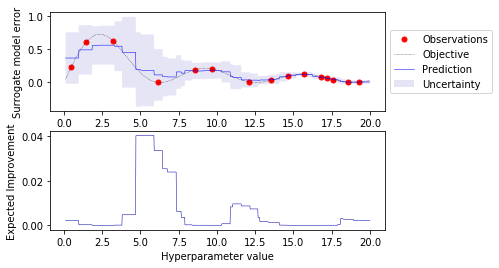

In [323]:
# Example usage (delete me)
import math
from random import randint

# Articifial objective function to optimize
x_points = np.linspace(0.1,20,1000)
y_points = (1 - np.cos(x_points)) / x_points
sample = np.random.choice(1000, 15)
x_train = x_points[sample]
y_train = y_points[sample]

# Surrogate model
rf = ProbabilisticRandomForestRegressor(n_estimators=100)
rf.fit(x_train.reshape(-1, 1),y_train) # Train surrogate model
y_pred, sigma = rf.predict(x_points.reshape(-1, 1), return_std=True)

# Plot surrogate model
plt.subplot(2, 1, 1)
plt.ylabel('Surrogate model error')
plt.plot(x_train, y_train, 'r.', markersize=10, label=u'Observations');
plt.plot(x_points, y_points, 'k:', label=u'Objective');
plt.plot(x_points, y_pred, 'b-', label=u'Prediction');
plt.fill_between(x_points.ravel(),y_pred-2*sigma,y_pred+2*sigma,alpha=0.1,label='Uncertainty');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Plot acquisition function
plt.subplot(2, 1, 2)
plt.xlabel('Hyperparameter value');
plt.ylabel('Expected Improvement')
plt.plot(x_points, EI(rf,x_points))
plt.show()

## Questions
- Hint: You can save time by reading all questions first and solving some of them simultaneously.

1_ Gaussian Processes (5 points)
* Implement Bayesian optimization using Gaussian Processes for the surrogate model and use it to optimize the hyperparameters of an SVM for the robot navigation training data
    - The evaluation measure should be misclassification error (1 - Accuracy), evaluated using 3-fold cross-validation
    - The hyperparameters and ranges are the same as in question 1, but sampled from a log scale (`numpy.logspace`) rather than a grid 
* Initialize the surrogate model with 10 randomly sampled configurations and visualize the surrogate model.
    - Hint: Use an interesting 2D slice of each hyperparameter (e.g. $C$=4 and $\gamma$=0.1) to show both the predicted values and the uncertainty.
* Visualize the resulting acquisition function, either as 2D slices or a 3D surface
* Visualize 3 more iterations, each time visualizing the surrogate model and acquisition function
* Run the Bayesian optimization for at least 30 iterations, report the optimal configuration and show the final surrogate model (2D slices or 3D surface).
* Interpret and explain the results. Does Bayesian optimization efficiently find good configurations? It is more efficient than a random search?

2_ Comparison with Random Search (2 points)
* Show the sequence of the selected Bayesian optimization configurations superimposed on the 2D heatmap from question 1, part 1. Label the initial 10 configuration as '0', the next one as '1', and so on.
* Time how long the Bayesian optimization takes, and compare this to a simple random search with at least 30 iterations
    - Hint: implement the timing from the start so that you only need to run the Bayesian optimization once
    - Hint: make sure that the timings are comparable. Don't parallelize the random search if you can't do the same for the Bayesian optimization.
* Plot the runtime (X-axis) against the performance (Y-axis), as a line with one point for every iteration (runtime and best configuration found thus far). It should show how fast each method converges to the optimal solution.
* Interpret and discuss the results. Is it worth doing the Bayesian optimization or is a random search sufficient? What do you expect to happen if you need to optimize many more hyperparameters?

3_ Random Forests (3 points)
* Repeat the previous 2 parts, but now using Random Forests as the surrogate model.
    - Hint: to save time (and code), implement the method in such a way that you only need to replace the Gaussian Process regressor with the random forest regressor
* Interpret and discuss the results. How is the surrogate model different from the one built with Gaussian Processes? Does the optimization work equally efficient? Does it converge faster than either the Gaussian Processes or random search? What do you expect to happen if you need to optimize many more hyperparameters?